# Spatial mapping of cell types across the mouse brain (2/3) - cell2location

This notebook demonstrates how to use the **cell2location** model for mapping a single cell reference cell types onto a spatial transcriptomic dataset. Here, we use a 10X single nucleus RNA-sequencing (snRNAseq) and Visium spatial transcriptomic data generated from adjacent tissue sections of the mouse brain (Kleshchevnikov et al., in preparation). 

The first step of our model (#2 in Fig 1, tutorial 1/3) is to estimate reference cell type signatures from scRNA-seq profiles, for example as obtained using conventional clustering to identify cell types and subpopulations followed by estimation of average cluster gene expression profiles ([Suppl. Methods, Section 2](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf), [Fig S1](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf)). Cell2location implements this estimation step based on Negative Binomial regression, which allows to robustly combine data across technologies and batches ([Suppl. Methods, Section 2](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf)).

![Figure 1.](../images/Fig1_v2.png)  
***Figure 1.*** *Overview of the spatial mapping approach and the workflow which are enabled by cell2location. From left to right: Single-cell RNA-seq and spatial transcriptomics profiles are generated from the same tissue (1). Cell2location takes reference cell type signatures derived from scRNA-seq and spatial transcriptomics data as input (2, 3). The model then decomposes spatially resolved multi-cell RNA counts matrices into the reference signatures, thereby establishing a spatial mapping of cell types (4).*


In the second step covered by this notebook (#4 in Fig 1), cell2location decomposes mRNA counts in spatial transcriptomic data using these reference signatures, thereby estimating the relative and absolute abundance of each cell type at each spatial location ([Suppl. Methods, Section 1](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf), [Fig S1](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf)). 

## Outline

The [**cell2location** workflow](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf) consists of three sections:

I. Estimating reference expression signatures of cell types (1/3):

1. Loading single cell reference data
2. Reduce the number of genes by discarding lowly expressed genes
3. Exploring the data: show UMAP of cells
4. Estimating expression signatures
5. Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow

II. Spatially mapping cell types (2/3, this notebook):

1. [Loading Visium data and single cell reference, QC](#1.-Loading-Visium-data-and-single-cell-reference)
2. [Exploring the data: UMAP of cells and locations](#2.-Show-UMAP-of-cells-and-locations)
3. [cell2location analysis pipeline](#3.-cell2location-analysis-pipeline)

III. Results and downstream analysis (3/3):

1. Loading cell2location results
2. Visialising cell locations
3. Discrete region identification by clustering cell abundances estimated by cell2location
4. Identifying groups of cell types with similar locations using matrix factorisation
5. Extras: Analyse cell type density gradients using diffusion maps


## Loading packages and setting up GPU

First, we need to load the relevant packages and tell cell2location to use the GPU. cell2location is written in pymc3 language for probabilistic modelling that uses a deep learning library called theano for heavy computations. While the package works on both GPU and CPU, using the GPU significantly shortens the computation time for 10X Visium datasets. Using the CPU is more feasible for smaller datasets with fewer spatial locations (e.g. Nanostring WTA technology). 

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

# this line forces theano to use the GPU and should go before importing cell2location
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# if using the CPU uncomment this:
#os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=float32,openmp=True,force_device=True'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/opt/conda/envs/cellpymc/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)


**Tips on initializing GPU** 
`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU. E.g. failure to use cuDNN will lead to significant slowdown.       

Above you should see a message similar to this confirming that `theano` started using the GPU:
```
/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)
```

Do not forget to change `device=cuda0` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job. You can see availlable GPU by openning a terminal in jupyter and running `nvidia-smi`. 

## 1. Loading Visium data and single cell reference <a name="1.-Loading-Visium-data-and-single-cell-reference"></a>

In this tutorial, we use a paired Visium and snRNAseq reference dataset of the mouse brain (i.e. generated from adjacent tissue sections). There are two biological replicates and several tissue sections from each brain, totalling 5 10X visium samples. 

First, we need to download and unzip spatial data, as well as download estimated signatures of reference cell types, from our data portal:

In [2]:
# Set paths to data and results used through the document:
sp_data_folder = './data/mouse_brain_visium_data/'
results_folder = './results/mouse_brain_snrna/'

regression_model_output = 'RegressionGeneBackgroundCoverageTorch_65covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

# Download and unzip spatial data
os.mkdir('./data')
os.system('cd ./data && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_visium_data.zip')
os.system('cd ./data && unzip mouse_brain_visium_data.zip')

# Download and unzip snRNA-seq data with signatures of reference cell types 
# (if the output folder was not created by tutorial 1/3)
if os.path.exists(reg_path) is not True:
    os.mkdir('./results')
    os.mkdir(f'{results_folder}')
    os.mkdir(f'{results_folder}regression_model')
    os.mkdir(f'{reg_path}')
    os.system(f'cd {reg_path} && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/regression_model/RegressionGeneBackgroundCoverageTorch_65covariates_40532cells_12819genes/sc.h5ad')

Now, let's read the spatial Visium data from the 10X Space Ranger output and examine several QC plots. Here, we load the our Visium mouse brain experiments (i.e. sections) and corresponding histology images into a single anndata object `adata`.

In [3]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.
    
    :param sample_name: Name of the sample
    :param path: path to data
    """
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.read_csv(sp_data_folder + 'Visium_mouse.csv')

# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path=sp_data_folder + 'rawdata/'))

# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)
#######################

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


<div class="alert alert-block alert-danger">
<b>Note!</b>
Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts we strongly recommend removing mitochondrial genes.
</div>

In [4]:
# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
adata = adata[:, ~adata.var['mt'].values]

### Look at QC metrics

Now let's look at QC: total number of counts and total number of genes per location across Visium experiments.

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


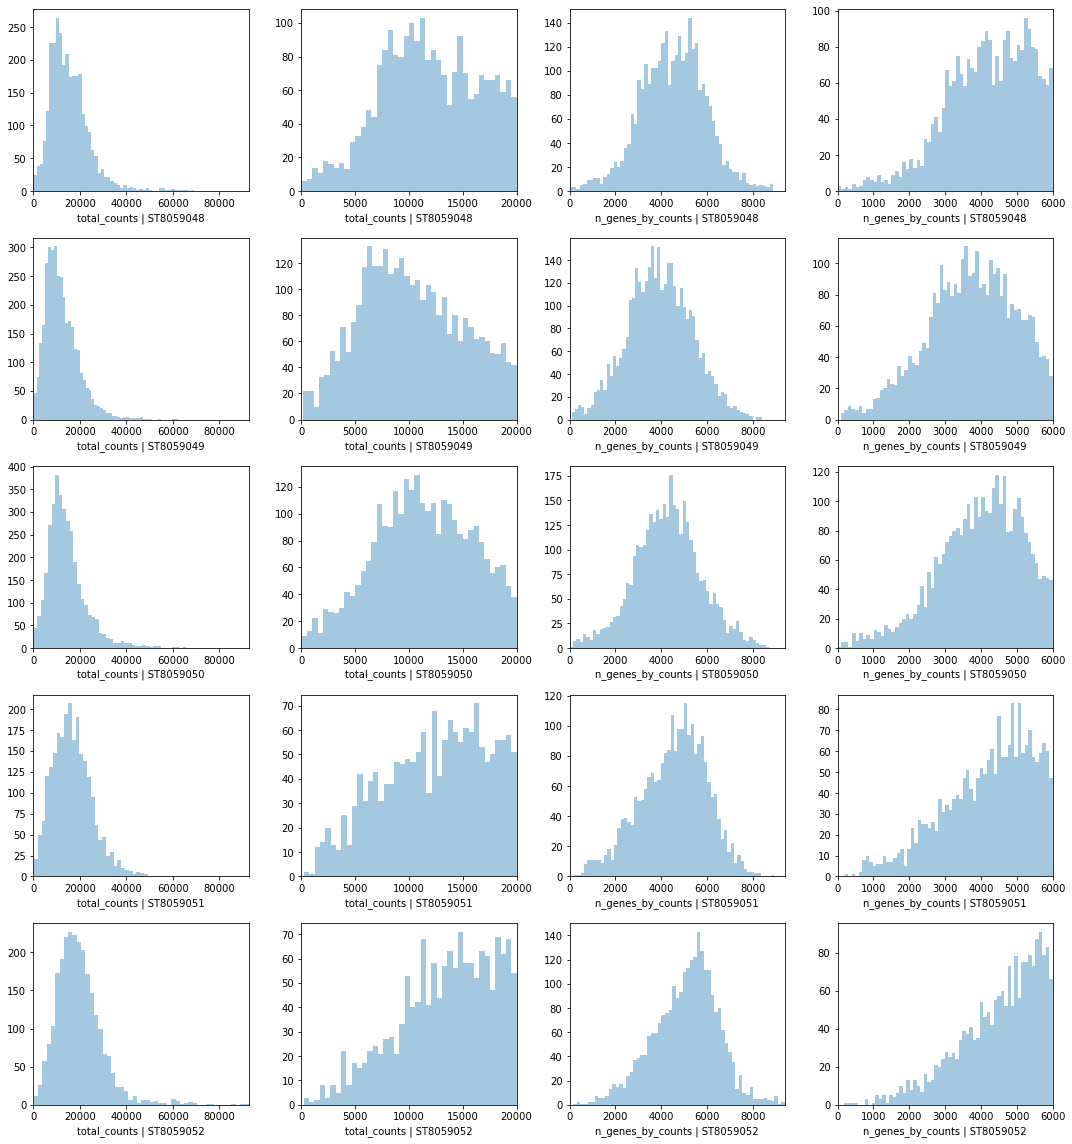

In [5]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')
    
    slide = select_slide(adata, s)
    sns.distplot(slide.obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')
    
    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')
    
    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')
    
    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')
    
plt.tight_layout()

### Visualising data in spatial coordinates with scanpy

Next, we show how to plot these QC values over the histology image using standard scanpy tools

Trying to set attribute `.uns` of view, copying.
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


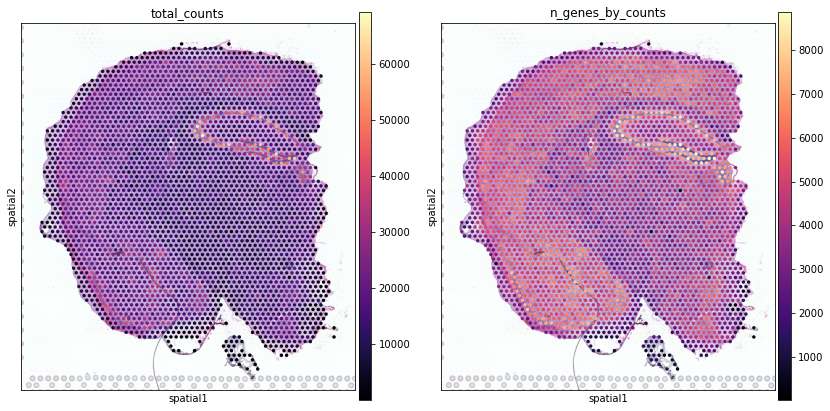

In [6]:
slide = select_slide(adata, 'ST8059048')

with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'white'}):
    sc.pl.spatial(slide, img_key = "hires", cmap='magma', 
                  library_id=list(slide.uns['spatial'].keys())[0],
                  color=['total_counts', 'n_genes_by_counts'], size=1,
                  gene_symbols='SYMBOL', show=False, return_fig=True)

Here we show how to use scanpy to plot the expression of individual genes without the histology image.

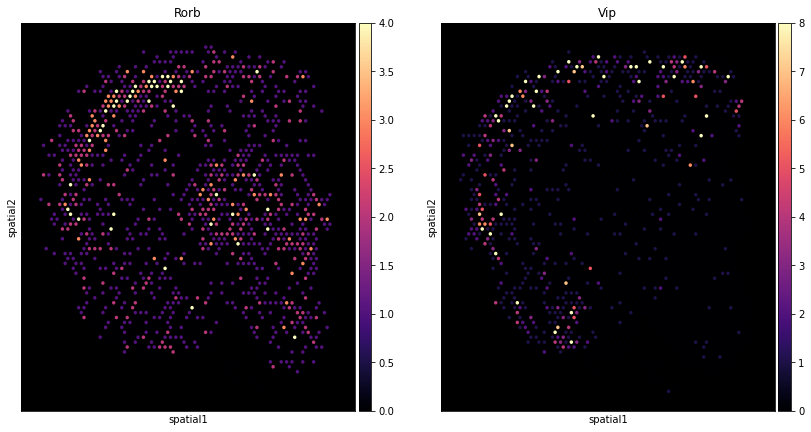

In [7]:
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(slide, 
                  color=["Rorb", "Vip"], img_key=None, size=1,
                  vmin=0, cmap='magma', vmax='p99.0',
                  gene_symbols='SYMBOL'
                 )

Add counts matrix as `adata.raw` 

In [8]:
adata_vis = adata.copy()
adata_vis.raw = adata_vis

Select two Visium samples to speed up the analysis, one from each biological replicate.

In [9]:
s = ['ST8059048', 'ST8059052']
adata_vis = adata_vis[adata_vis.obs['sample'].isin(s),:]

### Construct and examine UMAP of locations

Now we apply the standard scanpy processing pipeline to the spatial Visium data to show experiment to experiment variability in the data. Importatly, this workflow will show the extent of batch differences in your data (cell2location works on samples jointly, see below).

In this mouse brain dataset, only a few regions should be different between sections because we are using 2 samples from biological replicates sectioned at a slightly different location along the anterior-posterior axis in the mouse brain. We see general alighnment of locations from both experiments and some mismatches, but as you will see in the downstream analysis notebook most of the differences between experiments here come from batch effect, which cell2location can account for.

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


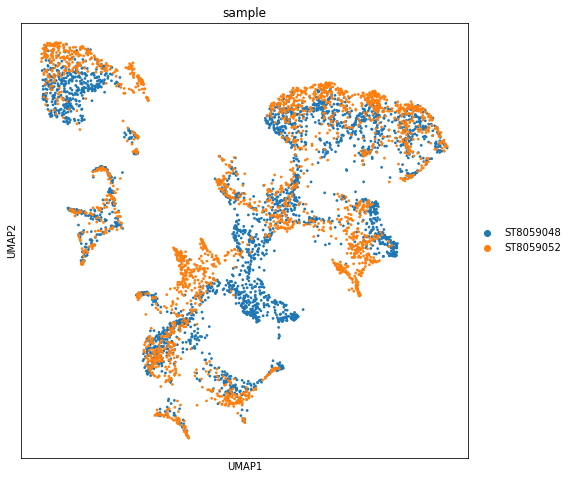

In [10]:
adata_vis_plt = adata_vis.copy()

# Log-transform (log(data + 1))
sc.pp.log1p(adata_vis_plt)

# Find highly variable genes within each sample
adata_vis_plt.var['highly_variable'] = False
for s in adata_vis_plt.obs['sample'].unique():
    
    adata_vis_plt_1 = adata_vis_plt[adata_vis_plt.obs['sample'].isin([s]), :]
    sc.pp.highly_variable_genes(adata_vis_plt_1, min_mean=0.0125, max_mean=5, min_disp=0.5, n_top_genes=1000)
    
    hvg_list = list(adata_vis_plt_1.var_names[adata_vis_plt_1.var['highly_variable']])
    adata_vis_plt.var.loc[hvg_list, 'highly_variable'] = True
    
# Scale the data ( (data - mean) / sd )
sc.pp.scale(adata_vis_plt, max_value=10)
# PCA, KNN construction, UMAP
sc.tl.pca(adata_vis_plt, svd_solver='arpack', n_comps=40, use_highly_variable=True)
sc.pp.neighbors(adata_vis_plt, n_neighbors = 20, n_pcs = 40, metric='cosine')
sc.tl.umap(adata_vis_plt, min_dist = 0.3, spread = 1)

with mpl.rc_context({'figure.figsize': [8, 8],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_vis_plt, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 1, #legend_loc='on data',
               legend_fontsize=10)

## 2. Load reference cell type signature from snRNA-seq data and show UMAP of cells <a name="2.-Load-reference-cell-type-signature-from-snRNA-seq-data-and-show-UMAP-of-cells"></a>

Next, we load the pre-processed snRNAseq reference anndata object that contains estimated expression signatures of reference cell types (see notebook 1/3).

In [11]:
## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

Export reference expression signatures of cell types:

In [12]:
# Column name containing cell type annotations
covariate_col_names = 'annotation_1'

# Extract a pd.DataFrame with signatures from anndata object
inf_aver = adata_snrna_raw.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_snrna_raw.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_snrna_raw.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# normalise by average experiment scaling factor (corrects for sequencing depth)
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

Quick look at the cell type composition in our reference data in UMAP coordinates (UMAP representation was generated using a standard scanpy workflow, see notebook 1/3).

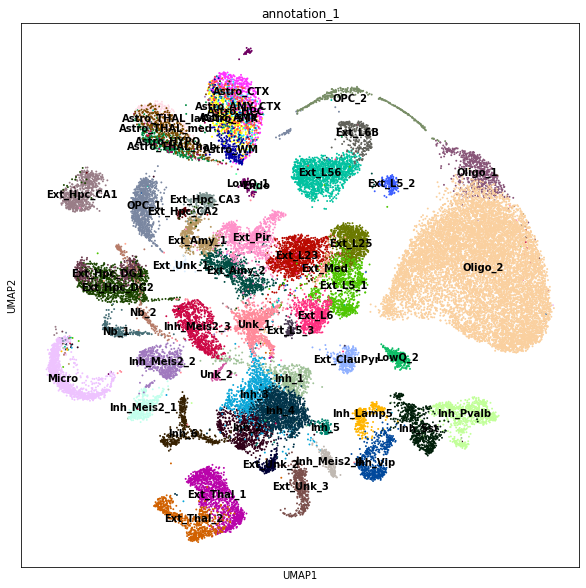

In [13]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['annotation_1'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

## 3. cell2location analysis pipeline <a name="3.-cell2location-analysis-pipeline"></a>

In this section we show how to run cell2location and how to choose hyperparameters.

Cell2location is implemented as an interpretable hierarchical Bayesian model, thereby (1) providing principled means to account for model uncertainty; (2) accounting for linear dependencies in cell type abundances, (3) modelling differences in measurement sensitivity across technologies, and (4) accounting for unexplained/residual variation by employing a flexible count-based error model. Finally, (5) cell2location support joint modelling of multiple experiments / batches.

### Brief description of the model

For a complete derivation of the cell2location model, please see [Suppl. Methods, Section 2](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf). Briefly, cell2location is a Bayesian model, which estimates absolute cell density of cell types by decomposing mRNA counts $d_{s,g}$ of each gene $g={1, .., G}$ at locations $s={1, .., S}$ into a set of predefined reference signatures of cell types $g_{fg}$. Joint modelling mode works across experiments $e=\{1,..,E\}$, such as 10X Visium chips (i.e. square capture areas) and Slide-Seq V2 pucks (i.e. beads).

Cell2location models the elements of $d_{s,g}$ as Negative Binomial distributed, given an unobserved rate $\mu_{s,g}$ and a gene-specific over-dispersion parameter $\alpha_{eg}$: 
$$
D_{s,g} \sim \mathtt{NB}(\mu_{s,g}, \alpha_{eg}) \\
$$

The expression level of genes $\mu_{s,g}$ in the mRNA count space is modelled as a linear function of expression signatures of reference cell types:
$$
\mu_{s,g} = \underbrace{m_{g}}_{\text{technology sensitivity}} \cdot \underbrace{\left (\sum_{f} {w_{s,f} \: g_{f,g}} \right)}_{\text{cell type contributions}} +  \underbrace{l_s + s_{eg}}_{\text{additive shift}}
$$

where, $w_{s,f}$ denotes regression weight of each reference signature $f$ at location $s$, which can be interpreted as the number of cells at location $s$ that express reference signature $f$; $m_{g}$ a gene-specific scaling parameter, which adjusts for global differences in sensitivity between technologies; $l_s$ and $s_{eg}$ are additive variables that account for gene- and location-specific shift, such as due to contaminating or free-floating RNA.

To account for the similarity of location patterns across cell types, $w_{s,f}$ is modelled using another layer of decomposition (factorization) using $r={1, .., R}$ groups of cell types, that can be interpreted as cellular compartments or tissue zones (Suppl. Methods). Unless stated otherwise, $R$ is set to 50.

### Selecting hyper-parameters

<div class="alert alert-block alert-warning">
<b>Note!</b>
While the scaling parameter $m_{g}$ facilitates the integration across technologies, it leads to non-identifiability between mgand $w_{s,f}$, unless the informative priors on both variables are used. To address this, we employ informative prior distributions on $w_{s,f}$ and $m_{g}$, which are controlled by 4 used-provided hyper-parameters.
    For guidance on selecting these hyper-parameters see below  and Suppl. Methods (Section 1.3).
</div>

For the mouse brain we suggest using the following values for 4 used-provided hyper-parameters: 
1. $\hat{N} = 8$, the expected number of cells per location, estimated based on comparison to histology image; 
2. $\hat{A} = 9$, the expected number of cell types per location, assuming that most cells in a given location belong to a different type and that many locations contain cell processes rather than complete cells; 
3. $\hat{Y} = 5$, the expected number of co-located cell type groups per location, assuming that very few cell types have linearly dependent abundance patterns, except for the regional astrocytes and corresponding neurons such that on average about 2 cell types per group are expected $\hat{A}/\hat{Y}=1.8$; 
4. mean and variance that define hyperprior on gene-specific scaling parameter $m_{g}$, allowing the user to define prior beliefs on the sensitivity of spatial technology compared to the scRNA-seq reference. 

### Joing modelling of multiple experiments

Joint modelling of spatial data sets from multiple experiments provides the several benefits due to sharing information between experiments (such as 10X Visium chips (i.e. square capture areas) and Slide-Seq V2 pucks (i.e. beads)):

- Increasing accuracy by improving the ability of the model to distinguish low sensitivity $m_{g}$ from zero cell abundance $w_{r,f}$, which is achieved by sharing the change in sensitivity between technologies $m_{g}$ across experiments. Similarly to common practice in single cell data analysis, this is equivalent to regressing out the effect of technology but not the effect of individual experiment.
    
- Increasing sensitivity by sharing information on cell types with co-varying abundances during decomposition of $w_{s,f}$ into groups of cell types $r={1, .., R}$.

### Gene selection

<div class="alert alert-block alert-warning">
<b>Note!</b>
For computational efficiency we suggest selecting genes by specificity of their expression to cell types.
</div>

Briefly, expression signatures of cell types are normalised to sum to 1 gene-wise (1 represents very specific expression to one cell type), then a cutoff is applied. With 59 cell types in our snRNA-seq, the cut off is low 0.1, but with less cell types it should be increase to include less genes. We observed slightly better performance of cell2location when selecting 2.5-6k marker genes (`'selection': "cluster_specificity"`). The data on all genes detected in snRNA-seq reference is used in the paper.

The code below shows how gene selection is performed and allows to adjust the cut-off to include more markers for specific cell types:

In [14]:
# selecting most informative genes based on specificity
selection_specificity = 0.05

# normalise expression signatures:
cell_state_df_norm = (inf_aver.T / inf_aver.sum(1)).T
# apply cut off:
cell_state_df_norm = (cell_state_df_norm > selection_specificity)

# check the number of markers per cell type
cell_state_df_norm.sum(0), cell_state_df_norm.sum(0).sum()

(Astro_AMY          237
 Astro_AMY_CTX      260
 Astro_CTX          279
 Astro_HPC          272
 Astro_HYPO         212
 Astro_STR          229
 Astro_THAL_hab     199
 Astro_THAL_lat     256
 Astro_THAL_med     227
 Astro_WM           157
 Endo               359
 Ext_Amy_1          380
 Ext_Amy_2          365
 Ext_ClauPyr        550
 Ext_Hpc_CA1        401
 Ext_Hpc_CA2        984
 Ext_Hpc_CA3        890
 Ext_Hpc_DG1        224
 Ext_Hpc_DG2        118
 Ext_L23            497
 Ext_L25            224
 Ext_L56            233
 Ext_L5_1           487
 Ext_L5_2          1254
 Ext_L5_3           407
 Ext_L6             363
 Ext_L6B            515
 Ext_Med            165
 Ext_Pir            509
 Ext_Thal_1         899
 Ext_Thal_2         544
 Ext_Unk_1          247
 Ext_Unk_2          202
 Ext_Unk_3          445
 Inh_1              199
 Inh_2              432
 Inh_3               67
 Inh_4              298
 Inh_5              482
 Inh_6              317
 Inh_Lamp5          256
 Inh_Meis2_1    

To do this selection, below set the option `'selection': "cluster_specificity"` and specify the cutoff via `'selection_specificity': 0.1`.

### Training cell2location: specifying data input and hyper-parameters

Here we show how to train cell2location model to estimate cell abundances in each location. This workflow is wrapped into a single pipeline:

In [15]:
sc.settings.set_figure_params(dpi = 100, color_map = 'viridis', dpi_save = 100,
                              vector_friendly = True, format = 'pdf',
                              facecolor='white')

r = cell2location.run_cell2location(
    
      # Single cell reference signatures as pd.DataFrame 
      # (could also be data as anndata object for estimating signatures 
      #  as cluster average expression - `sc_data=adata_snrna_raw`)
      sc_data=inf_aver, 
      # Spatial data as anndata object
      sp_data=adata_vis,

      # the column in sc_data.obs that gives cluster idenitity of each cell
      summ_sc_data_args={'cluster_col': "annotation_1",
                         # select marker genes of cell types by specificity of their expression signatures
                         'selection': "cluster_specificity", 
                         # specificity cutoff (1 = max, 0 = min)
                         'selection_specificity': 0.05
                        },

      train_args={'use_raw': True, # By default uses raw slots in both of the input datasets.
                  'n_iter': 40000, # Increase the number of iterations if needed (see QC below)
                  
                  # Whe analysing the data that contains multiple experiments, 
                  # cell2location automatically enters the mode which pools information across experiments
                  'sample_name_col': 'sample'}, # Column in sp_data.obs with experiment ID (see above)

    
      export_args={'path': results_folder, # path where to save results
                   'run_name_suffix': '' # optinal suffix to modify the name the run
                  },

      model_kwargs={ # Prior on the number of cells, cell types and co-located groups
          
                    'cell_number_prior': {
                        # - N - the expected number of cells per location:
                        'cells_per_spot': 8, 
                        # - A - the expected number of cell types per location:
                        'factors_per_spot': 9, 
                        # - Y - the expected number of co-located cell type groups per location
                        'combs_per_spot': 5
                    },
          
                     # Prior beliefs on the sensitivity of spatial technology:
                    'gene_level_prior':{
                        # Prior on the mean
                        'mean': 1/2, 
                        # Prior on standard deviation,
                        # a good choice of this value should be at least 2 times lower that the mean
                        'sd': 1/4
                    }
      }
)

### Summarising single cell clusters ###
### Creating model ### - time 0.02 min
### Analysis name: LocationModelLinearDependentWMultiExperiment_2experiments_59clusters_5563locations_6311genes
### Training model ###


Finished [100%]: Average Loss = 2.4021e+07


Finished [100%]: Average Loss = 2.4021e+07



### Sampling posterior ### - time 33.31 min



### Saving results ###


... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


### Ploting results ###
### Plotting posterior of W / cell locations ###
### Done ### - time 35.46 min


### Cell2location model output

The results are saved to:  

In [16]:
results_folder + r['run_name']

'./results/mouse_brain_snrna/LocationModelLinearDependentWMultiExperiment_2experiments_59clusters_5563locations_6311genes'

The absolute abundances of cell types are added to `sp_data` as columns of `sp_data.obs`. The estimates of all parameters in the model are exported to `sp_data.uns['mod']`. 

#### List of output files:

- **sp.h5ad** - Anndata object with all results and spatial data.   
- W_cell_density.csv - *absolute abundances of cell types*, mean of the posterior distribution.   
- ***(default)*** - W_cell_density_q05.csv - *absolute abundances of cell types*, 5% quantile of the posterior distribution representing confident cell abundance level.   
- W_mRNA_count.csv - *absolute mRNA abundance* for each cell types, mean of the posterior distribution.
- ***(useful for QC, selecting mapped cell types)*** - W_mRNA_count_q05.csv - *absolute mRNA abundance* for each cell types, 5% quantile of the posterior distribution representing confident cell abundance level.   

The same 4 estimates are also plotted for each cell type (saved to `r['run_name']/plots/scanpy`, on black background and overlayed on the histology image paired with each sample (saved with `histo_` prefix).


The downstream analysis notebook adds more results and creates the file:
- sp_with_clusters.h5ad

When `'save_model': True`, the trained model `r['mod']` is also saved as a pickle file. You can load the model later and continue training. 

In [17]:
r = {'run_name': 'LocationModelLinearDependentWMultiExperiment_2experiments_59clusters_5563locations_6311genes'}

### Evaluating training

Now we need to check if our model has trained successfully by examining a few diagnosic plots. 

First, we look at the ELBO loss / cost function over training iterations. This plot omits the first 20% of training iterations during which loss changes by many orders of magnitude. Here we see that the model converged by the end of training, some noise in the ELBO loss function is acceptable. If there are large changes during the last few thousands of iterations we recommend increasing the `'n_iter'` parameter. 

Divergence in ELBO loss between training iterations indicates the problem with training which can be caused by incomplete or insufficiently detailed reference of cell types.

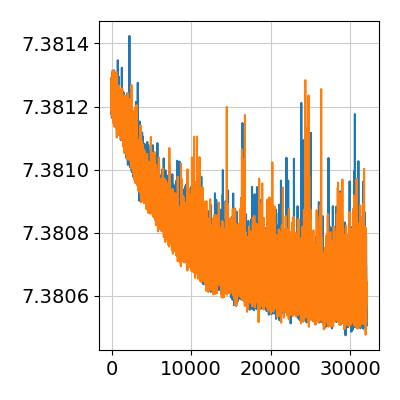

In [18]:
from IPython.display import Image
Image(filename=results_folder +r['run_name']+'/plots/training_history_without_first_20perc.png',
      width=400)

We also need to evaluate the reconstruction accuracy: how well reference cell type signatures explain spatial data by comparing expected value of the model $\mu_{s,g}$ (Negative Binomial mean) to observed count of each gene across locations. The ideal case is a perfect diagonal 2D histogram plot (across genes and locations). 

A very fuzzy diagonal or large deviations of some genes and locations from the diagonal plot indicate that the reference signatures are incomplete. The reference could be missing certain cell types entirely (e.g. FACS-sorting one cell lineage) or clustering could be not sufficiently granular (e.g. mapping 5-10 broad cell types to a complex tissue). Below is an example of good performance:

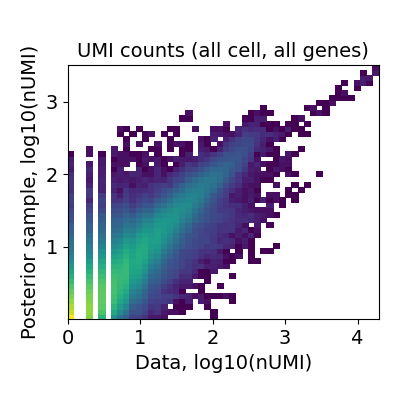

In [19]:
Image(filename=results_folder +r['run_name']+'/plots/data_vs_posterior_mean.png',
      width=400)

Finally, we need to evaluate robustness of the identified locations by comparing consistency of estimated cell abundances between two independent training restarts (X- and Y-axis). The plot below shows the correlation (color) between cell abundance profiles in 2 training restarts. Some cell types can be correlated, but excessive deviations from diagonal would indicate instability of the solution (we have not seen this so far).

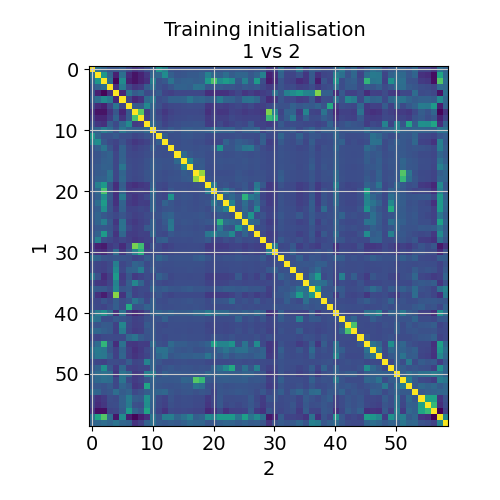

In [20]:
Image(filename=results_folder +r['run_name']+'/plots/evaluate_stability.png',
      width=400)

Modules and their versions used for this analysis

In [21]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

sys 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]
ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.19.0
IPython.core.release 7.19.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.19.0
pygments 2.7.2
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.8
tornado 6.1
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
scanpy 1.